Saving cameraman.jpg to cameraman.jpg
Gaussian kernel matrix:
[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


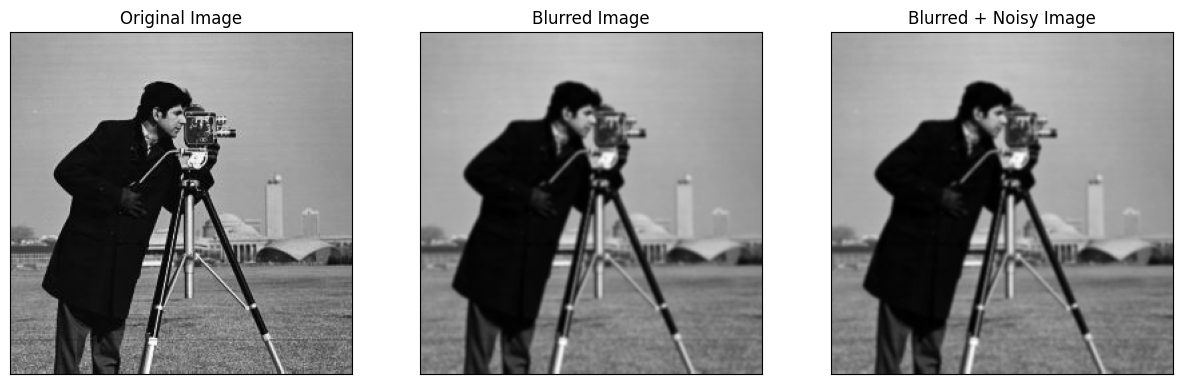

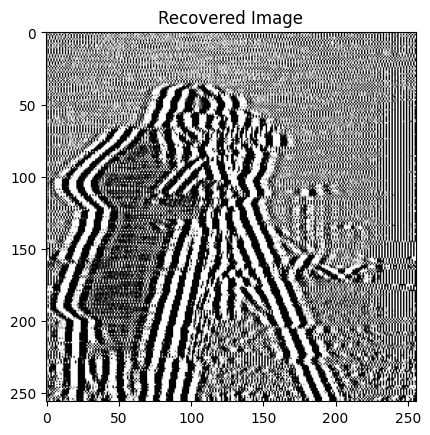

In [ ]:
import cv2
from google.colab import files
from matplotlib import pyplot as plt
import numpy as np

uploaded = files.upload()

file_name = next(iter(uploaded))

image = cv2.imread(file_name)

def create_gaussian_blur_kernel(kernel_size, sigma=0):
    gaussian_kernel_1d = cv2.getGaussianKernel(kernel_size, sigma)
    gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d.transpose())
    gaussian_kernel_2d /= np.sum(gaussian_kernel_2d)
    return gaussian_kernel_2d

kernel_size = 5
sigma = 1
gaussian_kernel = create_gaussian_blur_kernel(kernel_size, sigma)

print("Gaussian kernel matrix:")
print(gaussian_kernel)

image_blurred = cv2.filter2D(image, -1, gaussian_kernel)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_blurred_rgb = cv2.cvtColor(image_blurred, cv2.COLOR_BGR2RGB)

if len(image.shape) > 2 and image.shape[2] == 3:
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
else:
    image_gray = image

image_blurred = cv2.filter2D(image_gray, -1, gaussian_kernel)

mean_noise = 0
std_noise = 0.1

gaussian_noise = np.random.normal(mean_noise, std_noise, image_blurred.shape)

image_blurred_noisy = cv2.add(image_blurred.astype(np.float32), gaussian_noise.astype(np.float32))
image_blurred_noisy = np.clip(image_blurred_noisy, 0, 255).astype(np.uint8)

plt.figure(figsize=(15, 7))
plt.subplot(131), plt.imshow(image_gray, cmap='gray'), plt.title('Original Image')
plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(image_blurred, cmap='gray'), plt.title('Blurred Image')
plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(image_blurred_noisy, cmap='gray'), plt.title('Blurred + Noisy Image')
plt.xticks([]), plt.yticks([])
plt.show()

h = gaussian_kernel.flatten()

h_padded = np.pad(h, (0, len(image_blurred_noisy) - len(h)), 'constant')

H = np.fft.fft(h_padded)

G = 1 / (H + 0)

Y = np.fft.fft(image_blurred_noisy)

X = G * Y

x = np.fft.ifft(X).real

image_recovered = x.reshape((256, 256))

image_recovered = np.clip(image_recovered, 0, 255)

plt.imshow(image_recovered, cmap='gray')
plt.title('Recovered Image')
plt.show()

Exemple d'affichage d'un sample en utilisant cette loi dans le domaine de fourier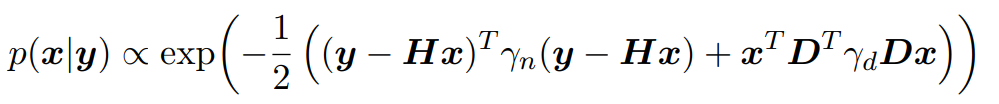

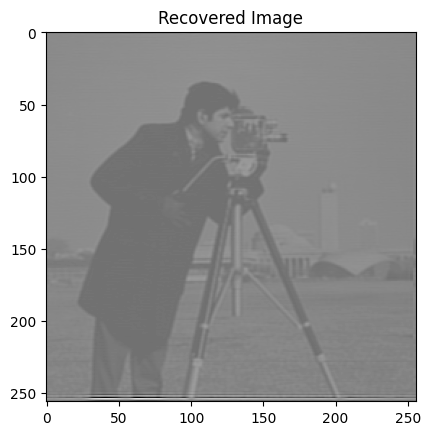

In [ ]:
import numpy as np

gamma_n = std_noise ** -2
gamma_d = 1
h = gaussian_kernel
y = image_blurred_noisy

# FFT de l'image observée
Y_f = np.fft.fft2(y)

# FFT du kernel
H_f = np.fft.fft2(h, s=y.shape)

# FFT de D
omega_x = np.fft.fftfreq(y.shape[1]) * 2 * np.pi
D_f = 1j * omega_x
D_f_2d = np.outer(np.ones(y.shape[0]), D_f)

# likelihood dans le domaine de fourier
precision_f = np.abs(H_f)**2 * gamma_n + np.abs(D_f_2d)**2 * gamma_d
mean_f = (np.conj(H_f) * gamma_n * Y_f) / precision_f  # Mean of x in the Fourier domain

# Sampling
noise_f = np.random.normal(size=mean_f.shape) / np.sqrt(precision_f)
noise_f = np.fft.ifft(np.fft.ifft2(noise_f))

x_sample_f = mean_f + noise_f

# FFT inverse
x_sample = np.fft.ifft2(x_sample_f).real

# affichage d'un sample
plt.imshow(x_sample, cmap='gray')
plt.title('Recovered Image')
plt.show()

**HMC**

<ipython-input-15-61e40c20886f>:43: RuntimeWarning: overflow encountered in exp
  if np.random.uniform() < np.exp(current_H - proposed_H):


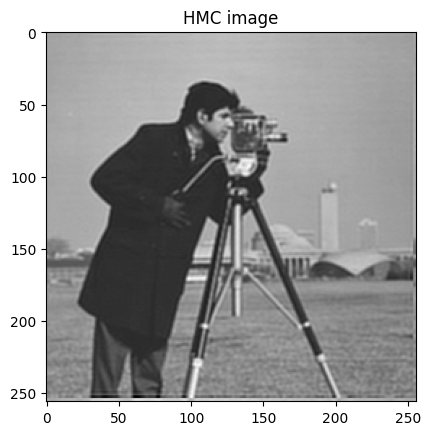

In [ ]:
import time
start_time = time.time()
# negative log-likelihood
def U(x, y, H_f, D_f, gamma_n, gamma_d):
    x_ft = np.fft.fft2(x)
    diff_ft = y - np.fft.ifft2(H_f * x_ft)
    Dx_ft = np.fft.ifft2(D_f * x_ft)
    return 0.5 * gamma_n * np.sum(np.abs(diff_ft) ** 2) + 0.5 * gamma_d * np.sum(np.abs(Dx_ft) ** 2)

# gradient
def grad_U(x, y, H_f, D_f, gamma_n, gamma_d):
    x_ft = np.fft.fft2(x)
    diff_ft = y - np.fft.ifft2(H_f * x_ft)
    grad_diff_ft = -np.conj(H_f) * np.fft.fft2(diff_ft)
    Dx_ft = D_f * x_ft
    grad_Dx_ft = np.conj(D_f) * Dx_ft
    return np.fft.ifft2(gamma_n * grad_diff_ft + gamma_d * grad_Dx_ft).real

# Leapfrog
def leapfrog(x, p, grad_U, stepsize, n_steps, *args):
    x = x.astype(np.float64)
    p = p.astype(np.float64)

    p -= 0.5 * stepsize * grad_U(x, *args)
    for i in range(n_steps - 1):
        x += stepsize * p
        p -= stepsize * grad_U(x, *args)
    x += stepsize * p
    p -= 0.5 * stepsize * grad_U(x, *args)
    return x, p

# Hamiltonian Monte Carlo
def hamiltonian_monte_carlo(n_samples, initial_x, stepsize, n_steps, *args):
    samples = []
    current_x = initial_x
    for i in range(n_samples):
        current_p = np.random.normal(size=current_x.shape)
        proposed_x, proposed_p = leapfrog(current_x, current_p, grad_U, stepsize, n_steps, *args)

        # acceptance
        current_H = U(current_x, *args) + np.sum(current_p**2) / 2
        proposed_H = U(proposed_x, *args) + np.sum(proposed_p**2) / 2
        if np.random.uniform() < np.exp(current_H - proposed_H):
            current_x = proposed_x

        samples.append(current_x)
    return samples

end_time = time.time()
hmc_processing_time = end_time - start_time

# Parameters
n_samples = 100
stepsize = 0.01
n_steps = 10
burn_in = 20

# x initial
initial_x = np.zeros_like(image_gray)

# Hamiltonian Monte Carlo
hmc_samples = hamiltonian_monte_carlo(n_samples, initial_x, stepsize, n_steps, image_blurred_noisy, H_f, D_f, gamma_n, gamma_d)

# burn-in samples
post_burn_in_samples = hmc_samples[burn_in:]

# la moyenne des samples après le burn-in
mean_sample = np.mean(post_burn_in_samples, axis=0)

# affichage de l'image moyenne
plt.imshow(mean_sample, cmap='gray')
plt.title('HMC image')
plt.show()

In [ ]:
hmc_processing_time

0.0010771751403808594

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

psnr_value = psnr(image_gray, mean_sample)
ssim_value = ssim(image_gray, mean_sample, data_range=mean_sample.max() - mean_sample.min())

<ipython-input-6-abfd0266179f>:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(image_gray, mean_sample)


In [ ]:
ssim_value

0.5740456857338756

In [ ]:
psnr_value

17.239148201084756

In [ ]:
from skimage.metrics import mean_squared_error as mse
mse_value = mse(image_gray, mean_sample)

mse_value

1227.9071854181211